<a href="https://colab.research.google.com/github/BarAvni/deep_learning_2020/blob/master/HW2_part_1_transfer_learning_Bar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_save_name = 'galaxy_classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

# Homework 2, part 1

## transfer learning
1. below you will find the dataset object for the galaxy dataset from homework 1, except that now it outputs a 69x69 image (no flattening), and the single grayscale channel is repeated 3 times to give a 3x69x69 image

2. load a pre-trained network from pytorchs selection https://pytorch.org/docs/stable/torchvision/models.html

3. create a network to classify the galaxy image dataset with some parts from the pretrained network

4. train the new network

5. when you reach over 75% accuracy on the validation dataset, submit your trained model (state_dict and source code)

6. double check that if you train the same model without the pre-trained weights, it will perform worse (no need to submit this model) 

In [0]:
#   to the ImageFolder structure
#data_dir = "E:/ML_weizmann/Dataset/Dataset/train/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 10

# Batch size for training (change depending on how much memory you have)
batch_size = 120

# Number of epochs to train for
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Learning rate decay
lr_decay_step_size=30 

In [6]:
#!wget -cq https://www.dropbox.com/s/r85ccs17j13rzd0/Dataset.zip?dl=0
#!unzip -qq Dataset.zip?dl=0

replace Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Dataset/train/class2_9417.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
path_to_training_data = "Dataset/train/"
path_to_validation_data = 'Dataset/validation/'

In [25]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda:0


In [0]:
import glob
from PIL import Image
from PIL import ImageFilter
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10,transform=False):
        
        self.mean = mean
        self.std = std
        
        self.do_transform = transform
        self.transform = transforms.RandomRotation(180)
        
        self.filelist = glob.glob(path+'/*.png')
        
        self.labels = np.zeros(len(self.filelist))
        
        for class_i in range(n_classes):
            self.labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        self.labels = torch.LongTensor(self.labels)
        
        
    def __len__(self):
       
        return len(self.filelist)

    def __getitem__(self, idx):
        
        img = Image.open(self.filelist[idx])
    
        if self.do_transform:
            
            img = self.transform(img)
            
        x = transforms.ToTensor()(img)#.unsqueeze_(0)
        
        x = (x-self.mean)/self.std
        
        x = x.repeat(3,1,1)
        x = transforms.ToPILImage()(x)#.squeeze_(0))
        transform = transforms.Compose([            #[1]
         transforms.Resize(244),                    #[2]
         transforms.CenterCrop(224),                #[3]
         transforms.ToTensor(),                     #[4]
         transforms.Normalize(                      #[5]
         mean=[0.485, 0.456, 0.406],                #[6]
         std=[0.229, 0.224, 0.225]                  #[7]
         )])
        x = transform(x)
        
        # x = x.unsqueeze(0)
        class_label = self.labels[idx]
        
        return x, class_label

## Load data (data loader)

In [0]:
train_ds = CustomDataset(path_to_training_data,transform=True)
valid_ds = CustomDataset(path_to_validation_data,transform=False)
# x - train and validation 
dataloaders = {'train': DataLoader(train_ds,batch_size=batch_size), 'val': DataLoader(valid_ds,batch_size=batch_size)}
# labels - target
training_labels = train_ds.labels.data.numpy()
validation_labels = valid_ds.labels.data.numpy()

In [0]:
x,y = train_ds[553]

In [12]:
x.shape

torch.Size([3, 224, 224])

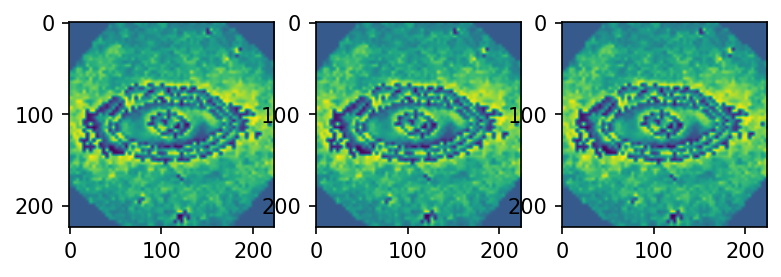

In [13]:
fig,ax = plt.subplots(1,3,figsize=(6,2),dpi=150)

for i in range(3):
    ax[i].imshow(x[i])

In [0]:
# import torchvision.models as models

# vgg16 = models.vgg16(pretrained=True)
# #vgg11 = models.vgg11(pretrained=False)

In [0]:
# vgg16

In [0]:
# ??vgg16

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [29]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        # model_ft.features[0] = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        # model_ft.features[3] = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        # model_ft.features[6] = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # model_ft.classifier[1] = nn.Linear(in_features=9216, out_features=4096, bias=True)
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        # model_ft.features[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # model_ft.features[4] = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # model_ft.features[8] = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # model_ft.features[11] = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # model_ft.features[15] = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # model_ft.classifier[0] = nn.Linear(in_features=25088, out_features=4096, bias=True)
        # model_ft.classifier[3] = nn.Linear(in_features=4096, out_features=4096, bias=True)
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Create the Optimizer
Now that the model structure is correct, the final step for finetuning and feature extracting is to create an optimizer that only updates the desired parameters. Recall that after loading the pretrained model, but before reshaping, if `feature_extract=True` we manually set all of the parameter’s `.requires_grad` attributes to False. Then the reinitialized layer’s parameters have `.requires_grad=True` by default. So now we know that all parameters that have `.requires_grad=True` should be optimized. Next, we make a list of such parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When finetuning, this list should be long and include all of the model parameters. However, when feature extracting this list should be short and only include the weights and biases of the reshaped layers.

In [30]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name, ": ", param.requires_grad)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name, ": ", param.requires_grad)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight :  True
	 features.0.bias :  True
	 features.3.weight :  True
	 features.3.bias :  True
	 features.6.weight :  True
	 features.6.bias :  True
	 features.8.weight :  True
	 features.8.bias :  True
	 features.10.weight :  True
	 features.10.bias :  True
	 classifier.1.weight :  True
	 classifier.1.bias :  True
	 classifier.4.weight :  True
	 classifier.4.bias :  True
	 classifier.6.weight :  True
	 classifier.6.bias :  True


## Run Training and Validation Step

In [0]:
# defining the loss function
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, lr_decay_step_size, gamma=0.1)

In [0]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
              scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)            
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [22]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/99
----------
train Loss: 1.3922 Acc: 0.4621
val Loss: 1.1517 Acc: 0.5476

Epoch 1/99
----------
train Loss: 1.0887 Acc: 0.5763
val Loss: 1.0539 Acc: 0.5988

Epoch 2/99
----------
train Loss: 1.0081 Acc: 0.6084
val Loss: 0.9614 Acc: 0.6352

Epoch 3/99
----------
train Loss: 0.9518 Acc: 0.6396
val Loss: 0.8642 Acc: 0.6742

Epoch 4/99
----------
train Loss: 0.8996 Acc: 0.6622
val Loss: 0.8119 Acc: 0.6896

Epoch 5/99
----------
train Loss: 0.8758 Acc: 0.6678
val Loss: 0.7923 Acc: 0.7036

Epoch 6/99
----------
train Loss: 0.8472 Acc: 0.6851
val Loss: 0.8043 Acc: 0.6994

Epoch 7/99
----------
train Loss: 0.8222 Acc: 0.6938
val Loss: 0.7858 Acc: 0.6986

Epoch 8/99
----------
train Loss: 0.8010 Acc: 0.6966
val Loss: 0.8129 Acc: 0.6898

Epoch 9/99
----------
train Loss: 0.7838 Acc: 0.7059
val Loss: 0.7810 Acc: 0.7050

Epoch 10/99
----------
train Loss: 0.7658 Acc: 0.7140
val Loss: 0.7727 Acc: 0.7068

Epoch 11/99
----------
train Loss: 0.7717 Acc: 0.7112
val Loss: 0.7149 Acc: 0.7304

Ep

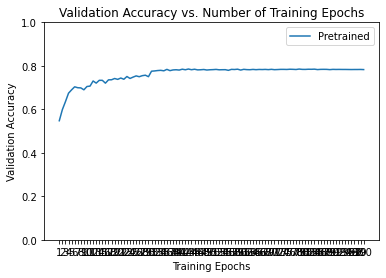

In [23]:
ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

torch.save(model_ft.state_dict(), 'model_alesxnet_fullylearned.pt')